# Project II: Economic Growth 

### By Astrid Fugleholm, Jacob Strabo, and Jørgen Høst

In [17]:
# Importing packages
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy.stats import norm
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

## 1. Read Data

In [18]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary

print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


### 1.1 Identify dummy variables

In [19]:
category_features = []
threshold = 2
for each in dat.columns:
    if dat[each].nunique() == threshold:
        category_features.append(each)

for each in category_features:
    dat[each] = dat[each].astype('category')

dummies = dat.select_dtypes('category')

## 2. Descriptive Plots

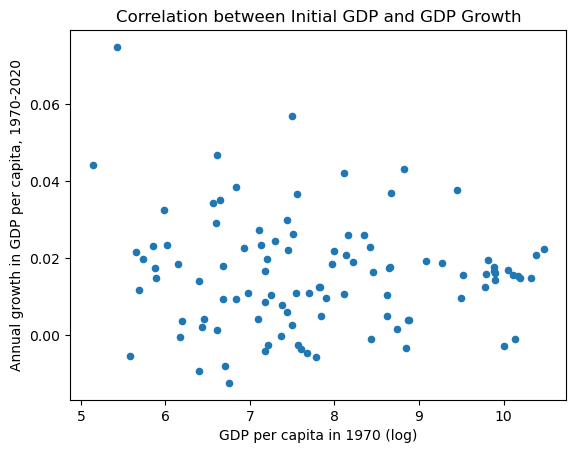

In [20]:
# Correlation between initial GDP level and GDP growth rate
fig1 = dat.plot.scatter(x='lgdp_initial', y='gdp_growth');
fig1.set_xlabel(lbl_all['lgdp_initial']);
fig1.set_ylabel(lbl_all['gdp_growth']);
fig1.set_title('Correlation between Initial GDP and GDP Growth');

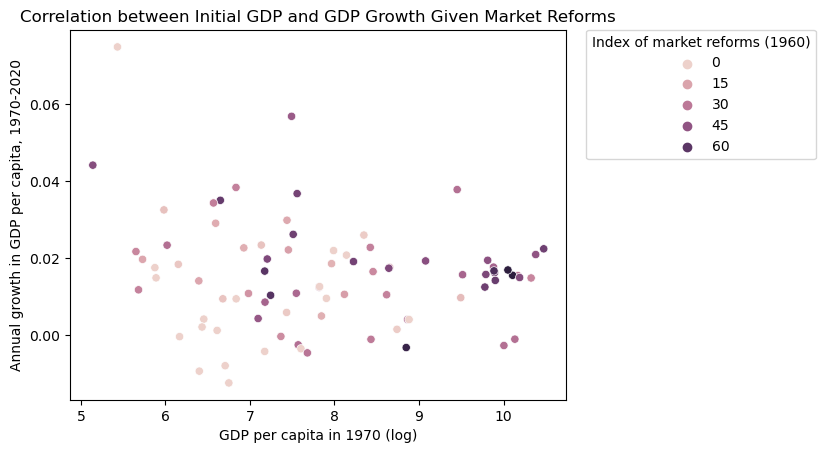

In [21]:
# Correlation between initial GDP and GDP growth with countries coloured depending on the number of market reforms implemented
fig2 = sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='marketref');
fig2.set_xlabel(lbl_all['lgdp_initial']);
fig2.set_ylabel(lbl_all['gdp_growth']);
fig2.legend(title=lbl_all['marketref'],loc=(1.04,0.65));
fig2.set_title('Correlation between Initial GDP and GDP Growth Given Market Reforms');

## 3. Collection of Variables

In order to make the analysis simpler, we collect variables in sets that belong together naturally. We do this based on all available variables, that is we have not discarded any variables deemed unnecessary yet.

In [22]:
# Variables regarding institutions
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 

# Variables regarding geography
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]

# Variables regarding genetic diversity
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']

# Variables regarding historical events
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']

# Variables regarding religion
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']

# Variables regarding the level of danger in countries
vv_danger = ['yellow', 'malfal',  'uvdamage']

# Variables regarding natural resources in countries
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']

# Variables regarding educational attainment level of populations in countries 
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

# A collection of all available variables grouped based on category
vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]

In [23]:
# We also create a column of ones that can serve as our constant
dat['constant'] = np.ones((dat.shape[0],))

## 4. Simple OLS as a Starting Point

In [24]:
# Removing observations with missings 
xs = ['constant', 'lgdp_initial']
I = dat[['gdp_growth'] + xs].notnull().all(axis=1)
print(I.shape)

(214,)


In [25]:
# The outcome variable gdp_growth is available for only some of the 214 countries
dat_ = dat['gdp_growth'].dropna()
print("Outcome variable gdp_growth is available for",dat_.shape[0],"of the 214 countries.")

Outcome variable gdp_growth is available for 102 of the 214 countries.


In [26]:
# Extracting y and X from our data set 
y = dat.loc[I, 'gdp_growth'].values.reshape((-1,1)) * 100.0
X = dat.loc[I, xs].values

In [27]:
print(y.shape)
print(X.shape)

(102, 1)
(102, 2)


### 4.1 Simple OLS without Controls

In [28]:
# Run a simple OLS without any controls as a starting point
betahat = np.linalg.inv(X.T @ X) @ X.T @ y
print(betahat)

[[ 2.24792211]
 [-0.08713416]]


In [29]:
# Reporting the results from the simple OLS estimation without any controls in a table
tab = pd.DataFrame({'beta': betahat.flatten()}, index=xs)
tab

,beta
constant,2.247922
lgdp_initial,-0.087134


The results from running a simple OLS regression of initial GDP in 1970 on GDP growth in 1970-2020 suggest that having a 1 pct. higher initial GDP decreases annual growth in GDP per capita growth by $0.09/100=0.0009$ pct. Or put differently, having a 1 pct. lower initial GDP will have increase annual growth in GDP per capita by $0.0009$ pct. 

### 4.2 Simple OLS with Controls

In [30]:
vs_ols = vv_all['geography'] + vv_all['religion']
xs_ols = ['constant', 'lgdp_initial', 'pop_growth', 'investment_rate'] + vs_ols

# avoiding missings
all_vars = ['gdp_growth'] + xs_ols
I = dat[all_vars].notnull().all(1)

# extract data
X_ols = dat.loc[I, xs_ols].values
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%

# check the rank condition
K = X_ols.shape[1]
assert np.linalg.matrix_rank(X_ols) == X_ols.shape[1], f'X_ols does not have full rank'

# compute the OLS estimator
betas = np.linalg.inv(X_ols.T @ X_ols) @ X_ols.T @ y

In [31]:
print(xs_ols)
print(X_ols.shape)

['constant', 'lgdp_initial', 'pop_growth', 'investment_rate', 'tropicar', 'distr', 'distcr', 'distc', 'suitavg', 'temp', 'suitgini', 'elevavg', 'elevstd', 'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough', 'landlock', 'africa', 'asia', 'oceania', 'americas', 'pprotest', 'pcatholic', 'pmuslim']
(89, 28)


In [32]:
# format nicely
print(f'Mean y = {y.mean(): 5.2f}% growth per year')
pd.DataFrame({'betahat': betas[:,0]}, index=xs_ols).round(3)

Mean y =  1.52% growth per year


,betahat
constant,18.405
lgdp_initial,-1.118
pop_growth,6.830
investment_rate,0.068
tropicar,-0.411
distr,-0.000
distcr,0.001
distc,-0.003
suitavg,-1.063
temp,-0.204


Results from running a simple OLS regression using various controls suggest that the negative effect from initial GDP on annual growth in GDP per capita is even larger when controlling for characteristics such as a country's capital formation, the share of land area in geographical tropics in a country, the population's religious affiliation, which continent the country is placed on, etc. The table above shows that having a 1 pct. lower initial GDP in 1970 increases annual growth in GDP per capita by $1.118/100=0.0118$ pct. The table also shows that some of the characteristics have relatively large impacts on the annual growth in GDP per capita; these include the annual population growth rate, land suitability for agriculture, mean elevation, terrain roughness, as well as being a country situated in either Africa, Asia, Oceania, or America. In particular, the coefficient on the dummy variable for being a country in Africa is $-2.354$ which means that being a country in Africa lowers annual GDP growth rate by $-2.345/100=-0.02$ pct. This shows that there may be other characteristics than initial GDP in 1970 determining the annual growth rate in GDP per capita implying that the simple OLS regression without controls suffers from omitted variable bias. 

## 5. Initial Selection of Controls

Ex ante, certain characteristics seem more important for predicting annual growth in GDP per capita. Before proceeding with our estimations using smarter methods, we therefore discard some of the available variables which we believe will be unimportant in our predictions. Part of our choice of variables hinges on the number of countries for which these variables are observed as a variable will have lower predictive power the fewer countries this information exists for. 

In [33]:
# Variables regarding institutions
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'democ00a', 'democ1', 'demreg'] 

# Variables regarding geography
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]

# Variables regarding genetic diversity
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']

# Variables regarding historical events
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']

# Variables regarding religion
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']

# Variables regarding the level of danger in countries
vv_danger = ['yellow', 'malfal',  'uvdamage']

# Variables regarding natural resources in countries
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']

# Variables regarding educational attainment level of populations in countries 
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

# A collection of all available variables grouped based on category
vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources,
          'educ':vv_educ
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]

In [34]:
# Variables used for AG
vv_ag = ['abslat','africa','americas','area','area_ar','asia','cenlong','code','elevavg', \
         'elevstd','europe','kgatr','legor_fr','legor_uk','ln_yst','ln_yst_aa','malfal', \
         'oceania','peatholic','pd1','pd1000','pd1500','pdiv','pdiv_aa','pdivhmi','pdivhmi_aa', \
         'pmuslim','pop1','pop1000','pop1500','pother','pprotest','precip','rough','suitavg', \
         'suitgini','temp','uvdamage']

# Variables used for AR
vv_ar = ['cons00a','currentinst','democ00a','democ1','excolony','goldm','imputedmort','imr95', \
         'iron','landlock','leb95','lt100km','mortality','oilres','silv','yellow','zinc']

# Variables used for ANRR
vv_anrr = ['dem','dembmr','demcgv','demreg','distc','distcr','distr','ginv','lh_bl','lp_bl', \
           'ls_bl','marketref','polity','polity2','tropicar']

In [35]:
vs_las = vv_all['institutions'] + vv_all['geography'] + vv_all['historical'] + vv_all['religion'] + vv_all['resources'] + vv_all['educ']

xs_las = ['lgdp_initial', 'pop_growth', 'investment_rate'] + vs_las

# avoiding missings
all_vars = ['gdp_growth'] + xs_las
I = dat[all_vars].notnull().all(1)

# extract data
X_las = dat.loc[I, xs_las].values
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%

# check rank
print(X.shape)
print(X_las.shape)

# Save names for later
varnames = list(dat.loc[I, xs_las].columns)

# check the rank condition
#K = X_las.shape[1]
#assert np.linalg.matrix_rank(X_las) == X_las.shape[1], f'X_las does not have full rank'

(102, 2)
(46, 46)


We consider as unimportant characteristics regarding institutions, geography, history (population numbers and density), religious afficiliation, natural resources, and education (as a proxy for human capital). We discard characteristics regarding the genetic diversity and dangers (e.g., yellow fewer, uv exposure, and malaria). While the discarded characteristics may be able to help predict annual growth in GDP per capita to some extent, it is our belief that the selected variables will do a better job, and for the sake of minimizing our vector of explanatory variables in this high-dimensional paradigm, we discard those with the weakest prediction power. 

We will then proceed by treating this new list of variables in a high-dimensional paradigm. 

## 6. Lasso

As we would like to include as many controls as possible in our regression, and we have a data set with observations on 102 countries and 85 variables, OLS will not be feasible. Further, we believe that our ability to select the most important variables for predicting annual growth rate in GDP per capita are not as good as estimators like Lasso, we rely on these smarter methods for our predictions. 

We start by normalizing our control variables, because Lasso is sensitive to the scaling of variables in the sense that variables measured on smaller scales which thereby have bigger standard deviations will receive a larger penalty in the Lasso estimation. When control variables have been standardized, the interpretation of coefficients will be the effect on annual growhth in GDP per capita from a 1 standard deviation change in a control variable. 

In [36]:
# Standardizing control variables
def standardize(X):
    X_tilde = (X-X.mean())/X.std()
    return X_tilde

X_tilde=standardize(X_las)
X_tilde.shape

(46, 46)

### 6.1.1: Simple Lasso (not HD)

We estimate the model using a simple Lasso based on a grid of candidate penalty levels from 1 to 80.000.  

$$
\left(\widehat{\beta}_0(\lambda), \widehat{\beta}(\lambda)\right) \in \underset{\left(b_0, b\right) \in \mathbf{R}^{1+p}}{\operatorname{argmin}}\left\{\frac{1}{2 n} \sum_{i=1}^n\left(Y_i-b_0-X_i^{\prime} b\right)^2+\lambda \sum_{j=1}^p\left|b_j\right|\right\}
$$

In [37]:
# Creating a grid of candidate penalty levels
penalty_grid = np.geomspace(1e-8,1e-2)

# Empty list for coefs
coefs=[]

# Estimating the model using Lasso for a given penalty level over a lopp using sklearn.linear_model.Lasso
for l in penalty_grid:
    clf = Lasso(alpha=l, max_iter=100000)
    clf.fit(X_tilde,y)
    coefs.append(clf.coef_)

We construct a Lasso path which visualizes which control variables are being shut down for given penalty levels. This will reveal which variables are most reasonable to include in our estimation in the sense that they are important for prediction annual growth in GDP per capita.  

### Coefficients not equal to zero

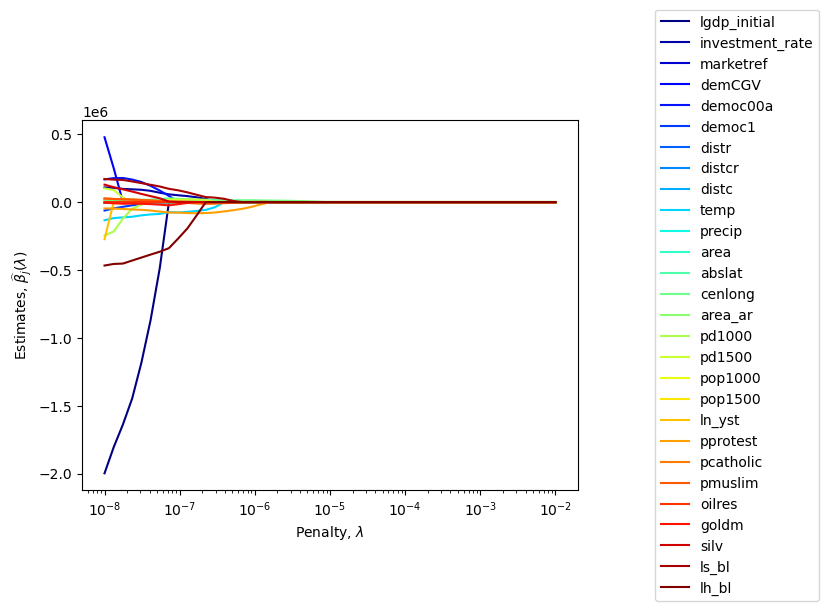

In [38]:
df = pd.DataFrame(dict(zip(penalty_grid,coefs)), index=varnames)
df_no_zeros = df.loc[(df!=0).any(axis=1)].T.plot(logx=True, colormap='jet').legend(loc='center right', bbox_to_anchor=(1.5,0.5))
plt.xlabel('Penalty, $\lambda$')
plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
plt.savefig('_draft_fig_lasso.pdf', bbox_inches = "tight")

### 6.1.2: LASSO (HD, polynomial features added)

c:\Users\JBH\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.052e+01, tolerance: 6.982e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\JBH\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.103e+01, tolerance: 6.982e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\JBH\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.142e+01, tolerance: 6.9

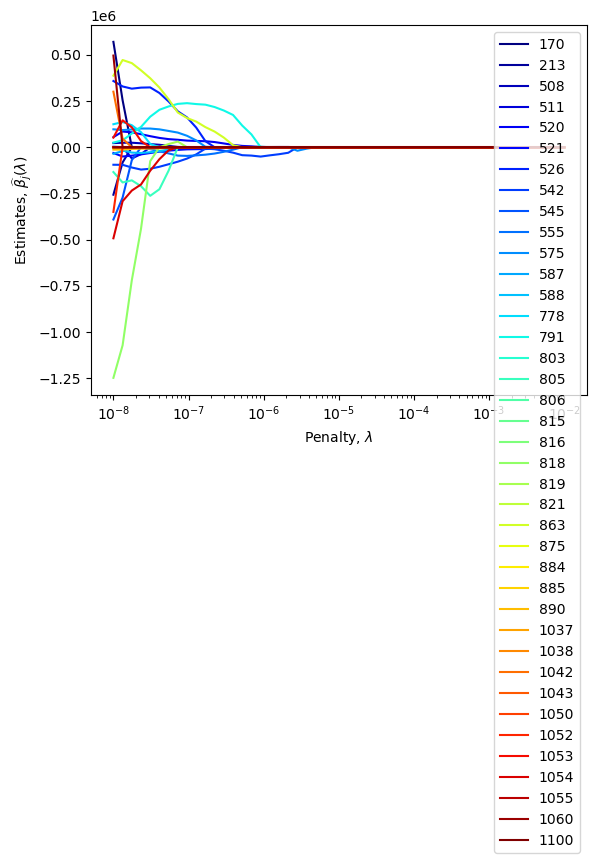

In [39]:
poly = PolynomialFeatures(2)

X_las_poly = poly.fit_transform(X_las)

X_tilde_poly = standardize(X_las_poly)

# Creating a grid of candidate penalty levels
penalty_grid = np.geomspace(1e-8,1e-2)

# Empty list for coefs
coefs=[]

# Estimating the model using Lasso for a given penalty level over a lopp using sklearn.linear_model.Lasso
for l in penalty_grid:
    clf = Lasso(alpha=l, max_iter=100000, tol=1e-1)
    clf.fit(X_tilde_poly,y)
    coefs.append(clf.coef_)

df = pd.DataFrame(dict(zip(penalty_grid,coefs)))
df_no_zeros = df.loc[(df!=0).any(axis=1)].T.plot(logx=True, colormap='jet')
plt.xlabel('Penalty, $\lambda$')
plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
plt.savefig(f'_draft_fig_lasso_poly.pdf', bbox_inches = "tight")

### 6.1.3: LASSO (HD, 95% rule, polynomial features added)

Method: On the basis of `materialize.ipynb`, select variables that has *at least* 90%-95% non-missing observations of GDP growth.

In [40]:
share_of_non_mis_obs = 0.95

temp = dat[dat.gdp_growth.notnull()].notnull().mean()>share_of_non_mis_obs
temp2 = temp.to_dict()

# Delete vars that has less than 90% non-missing obs for GDP growth
# NB! Not necessarily optimising the number of observations (different pairs could yield the higher number of observations)
for key, val in temp2.copy().items():
    if val == False:
        del temp2[key]

# Save the 'vars' for later
vars_to_keep = list(temp2.keys())

In [51]:
vs_las = vv_all['institutions'] + vv_all['geography'] + vv_all['historical'] + vv_all['religion'] + vv_all['resources'] + vv_all['educ']

vs_las_final = [item for item in vs_las if item in vars_to_keep]

# Based on our '95%' rule, select variables 

# Possible controls (z_i)
z_las_final = ['pop_growth', 'investment_rate'] + vs_las_final

# Initial gdp (beta)
b_las_final = ['lgdp_initial']

In [60]:
# avoiding missings
all_vars = ['gdp_growth'] + z_las_final + b_las_final
I = dat[all_vars].notnull().all(1)

# extract data (We split it up, this makes sense later)
# Possible controls (z_i)
Z_las_95_rule = dat.loc[I, z_las_final].values  

# Initial GDP (beta)
B_las_95_rule = dat.loc[I, b_las_final].values 

# Stack both X=np.hstack(())
X_las_95_rule = np.column_stack((B_las_95_rule,Z_las_95_rule))

y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%

In [61]:
X_las_95_rule.shape

(92, 27)

In [62]:
# Add polynomial features and interaction terms
X_poly_95 = poly.fit_transform(X_las_95_rule)

# Standardize our data (including intial GDP)
X_tilde_poly_95 = standardize(X_poly_95)

X_tilde_poly_95.shape

(92, 406)

In [44]:
# Creating a grid of candidate penalty levels
penalty_grid = np.geomspace(1e-8,1e-2)

# Empty list for coefs
coefs=[]

# Estimating the model using Lasso for a given penalty level over a lopp using sklearn.linear_model.Lasso
for l in penalty_grid:
    clf = Lasso(alpha=l, max_iter=100000)
    clf.fit(X_tilde_poly_95,y)
    coefs.append(clf.coef_)

c:\Users\JBH\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.593e+01, tolerance: 1.936e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\JBH\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.724e+01, tolerance: 1.936e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\JBH\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.858e+01, tolerance: 1.9

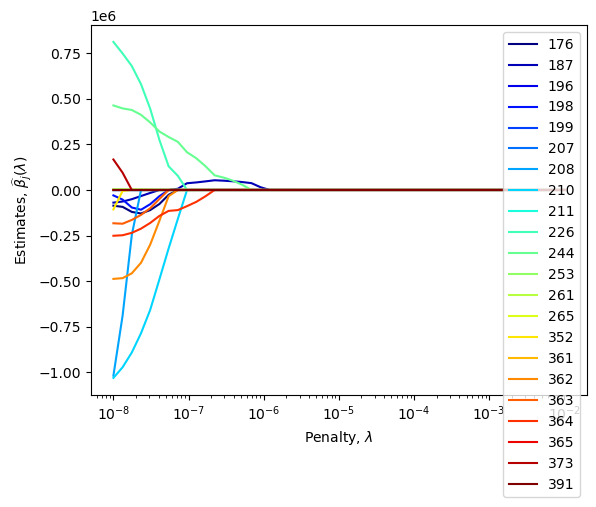

In [45]:
df = pd.DataFrame(dict(zip(penalty_grid,coefs)))
df_no_zeros = df.loc[(df!=0).any(axis=1)].T.plot(logx=True, colormap='jet')
plt.xlabel('Penalty, $\lambda$')
plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
plt.savefig(f'_draft_fig_lasso_poly_{share_of_non_mis_obs}_rule.pdf', bbox_inches = "tight")

### 6.2. Lasso with Cross Validation 

Would avoid CV, as we have such a small dataset...

### 6.3. Lasso with BRT

\begin{align}
    \hat{\lambda}^{B R T}   &=\frac{2 c \sigma}{\sqrt{N}} \Phi^{-1}\left(1-\frac{\alpha}{2 p}\right) \sqrt{\max _{1 \leq j \leq p} \frac{1}{N} \sum_{i=1}^N \mathbf{X}_i^2} \Leftrightarrow \\

    \hat{\lambda}^{B R T}   &=\frac{2 c \sigma}{\sqrt{N}} \Phi^{-1}\left(1-\frac{\alpha}{2 p}\right)
\end{align}

The last term = 1 only happens, if standardize $\mathbf{X}_i$.

In [46]:
def penalty_BRT(X_tilde,y):
    sigma = np.std(y)
    (N,p) = X_tilde.shape
    c = 1.1
    alpha = 0.05

    penalty_BRT= ((2*c*sigma)/np.sqrt(N))*(norm.ppf(1-alpha/(2*p)))

    return penalty_BRT

lambda_BRT = penalty_BRT(X_tilde_poly_95, y)

clf_BRT = Lasso(alpha=lambda_BRT/2)

clf_BRT.fit(X_tilde_poly_95, y)
coeff_BRT =clf_BRT.coef_

print("lambda_BRT =",(lambda_BRT/2).round(2))

lambda_BRT = 0.64


### 6.4 Lasso with BCCH

$$
\hat{\lambda}^{\text {pilot }}=\frac{2 c}{\sqrt{N}} \Phi^{-1}\left(1-\frac{\alpha}{2 p}\right) \sqrt{\max _{1 \leq j \leq p} \frac{1}{N} \sum_{i=1}^N\left(Y_i-\bar{Y}\right)^2\textcolor{red}{'} \mathbf{X}_i^2}
$$

Then,

$$
\hat{\lambda}^{B C C H}=\frac{2 c}{\sqrt{N}} \Phi^{-1}\left(1-\frac{\alpha}{2 p}\right) \sqrt{\max _{1 \leq j \leq p} \frac{1}{N} \sum_{i=1}^N \hat{\epsilon}_i^{\textcolor{red}{2}} \mathbf{X}_i^2}
$$

In [47]:
def penalty_BCCH(X_tilde,y):
    
    (N,p) = X_tilde.shape
    c = 1.1
    alpha = 0.05

    yXscale = (np.max((X_tilde.T ** 2) @ ((y-np.mean(y)) ** 2) / N)) ** 0.5

    penalty_pilot =  ((2*c*norm.ppf(1-alpha/(2*p)))/np.sqrt(N)) * yXscale

    clf_pilot = Lasso(alpha=penalty_pilot/2)

    fit_pilot= clf_pilot.fit(X_tilde,y)

    preds = clf_pilot.predict(X_tilde)

    eps =  y-preds
    epsXscale = (np.max((X_tilde.T ** 2) @ (eps ** 2) / N)) ** 0.5

    lambda_BCCH =  ((2*c*norm.ppf(1-alpha/(2*p)))/np.sqrt(N)) * epsXscale

    return lambda_BCCH

lambda_BCCH = penalty_BCCH(X_tilde_poly_95, y)

print('lambda_BCCH=', lambda_BCCH/2)

lambda_BCCH= 48.01448120863915


## 7. Post-Lasso
### 7.1 Partialling Put Lasso

$$
\hat{\alpha}=\frac{\sum_{i=1}^N\left(Y_i-\mathbf{Z}_{i, J, Y} \hat{\boldsymbol{\phi}}\right)\left(D_i-\mathbf{Z}_{i, J, D} \hat{\boldsymbol{\delta}}\right)}{\sum_{i=1}^N\left(D_i-\mathbf{Z}_{i, J, D} \hat{\boldsymbol{\delta}}\right)^2}=\frac{\sum_{i=1}^N \hat{v}_i \hat{w}_i}{\sum_{i=1}^N \hat{w}_i^2}
$$

1) Lasso `gdp_growth` on controls $z_i$ (based on 95% rule). Save residuals.
2) Lasso `initial_gdp` on controls $z_i$. Save residuals
3) Calculate $\hat{\alpha}$
4) Calculate variance & confidence interval
    - Lasso ``

In [72]:
### STEP 0 ###
# Standardize initial GDP
B_tilde_95_rule = standardize(B_las_95_rule)

# Standardize our candidate controls z_i
Z_tilde_95_rule = standardize(Z_las_95_rule)

### STEP 1 ###
# Calculate penalty, based on LASSOing gdp_growth (y) on controls (z_i).
# Lasso GDP-growth on controls z_i
penalty_BRT_yz = penalty_BRT(X_tilde=Z_tilde_95_rule, y=y)
clf_BRT_yz = Lasso(alpha=penalty_BRT_yz/2)
clf_BRT_yz.fit(Z_tilde_95_rule, y)
preds_yz = clf_BRT_yz.predict(Z_tilde_95_rule)

# Saving residuals
res_yz = y-preds_yz

### STEP 2 ###
# Calculate penalty, based on LASSOing initial GDP on controls (z_I)
# LASSO initial GDP on controls
penalty_BRT_bz = penalty_BRT(X_tilde=Z_tilde_95_rule, y=B_las_95_rule)
clf_BRT_bz = Lasso(alpha=penalty_BRT_bz/2)
clf_BRT_bz.fit(Z_tilde_95_rule, B_las_95_rule)
preds_bz = clf_BRT_bz.predict(Z_tilde_95_rule)

# Saving residuals
res_bz = B_las_95_rule-preds_bz

### STEP 3 ###
# Calculating estimate
numerator = np.sum(res_yz*res_bz)
denominator = np.sum(res_bz**2)

# Post Partialing Out LASSO estimate
POL = numerator/denominator

### STEP 4 ###
# 

-0.1871679363293528

### Addendum

- Should we standardize whole dataset, including dummies?
- Or should we first, standardize dataset excluding dummies, then stack dummies, and adding interaction terms?

In [48]:
# Extract dummies 
list_of_dummies = []
threshold = 2
for var_name in X_las_95_rule_df.columns:
    if X_las_95_rule_df[var_name].nunique() == threshold:
        list_of_dummies.append(var_name)

for var_name in list_of_dummies:
    X_las_95_rule_df[var_name] = X_las_95_rule_df[var_name].astype('category')

dummies = X_las_95_rule_df.select_dtypes('category').to_numpy()

X_las_95_rule_df=X_las_95_rule_df.drop(list_of_dummies, axis=1)
# Standardize our data (minus our dummies)
X_tilde_poly = standardize(X_las_95_rule_df)

# Stack our standardized data with our dummies
X_tilde_poly = np.hstack((X_las_95_rule, dummies))

# Add polynomial features and interaction terms
X_tilde_poly = poly.fit_transform(X_tilde_poly)